# Air-Quality classification

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import math
from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import warnings
import sweetviz
from scipy.stats import skew, kurtosis
import joblib

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
pd.options.display.float_format="{:,.2f}".format

### Data Ingestion

In [92]:
path = r"./data/updated_pollution_dataset.csv"
data = pd.read_csv(path)

### Exploratory Data Analysis

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4555 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    4555 non-null   float64
 1   Humidity                       4555 non-null   float64
 2   PM10                           4555 non-null   float64
 3   NO2                            4555 non-null   float64
 4   SO2                            4555 non-null   float64
 5   CO                             4555 non-null   float64
 6   Proximity_to_Industrial_Areas  4555 non-null   float64
 7   Population_Density             4555 non-null   int64  
 8   Air Quality                    4555 non-null   int32  
dtypes: float64(7), int32(1), int64(1)
memory usage: 338.1 KB


In [62]:
data.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.80,59.10,5.20,17.90,18.90,9.20,1.72,6.30,319,Moderate
1,28.30,75.60,2.30,12.20,30.80,9.70,1.64,6.00,611,Moderate
2,23.10,74.70,26.70,33.80,24.40,12.60,1.63,5.20,619,Moderate
3,27.10,39.10,6.10,6.30,13.50,5.30,1.15,11.10,551,Good
4,26.50,70.70,6.90,16.00,21.90,5.60,1.01,12.70,303,Good


In [63]:
data.isna().sum() # checking for null values

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64

In [64]:
def missing_value_analysis(df):
    """
    Analyzes missing values in the DataFrame.
    """
    
    # Calculate missing value count and percentage
    missing_count = df.isnull().sum()
    missing_percent = (df.isnull().mean()) * 100
    
    # Create a DataFrame to store results
    missing_report = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Percent': missing_percent
    })
    
    # Filter to show only columns with missing values
    missing_report = missing_report[missing_report['Missing Count'] > 0]
    
    # Sort by percentage of missing values in descending order
    missing_report = missing_report.sort_values(by='Missing Percent', ascending=False)
    
    return missing_report

def outlier_analysis(df):
    """
    Performs outlier analysis for numeric columns using the IQR method.
    """
    
    result = {}
    
    # Iterate through numeric columns
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        # Compute IQR (Interquartile Range)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        result[col] = outliers
    
    # Convert result to DataFrame for better readability
    outlier_report = pd.DataFrame(result.items(), columns=['Column', 'Outlier Count'])
    outlier_report = outlier_report.sort_values(by='Outlier Count', ascending=False)
    
    return outlier_report

def univariate_numeric_analysis(df, col):
    result = {}
    result['missing_percent'] = df[col].isnull().mean() * 100
    result['skewness'] = skew(df[col].dropna())
    result['kurtosis'] = kurtosis(df[col].dropna())
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    
    plt.show()
    
    return result

def univariate_categorical_analysis(df, col):
    """
    Performs univariate analysis for a categorical feature.
    """
    
    # Initialize result dictionary
    result = {}
    
    # Basic statistics
    result['unique_values'] = df[col].nunique()
    result['most_frequent'] = df[col].mode().iloc[0]
    result['frequency_counts'] = df[col].value_counts().to_dict()
    result['missing_percent'] = df[col].isnull().mean() * 100
    result['top_5_categories'] = df[col].value_counts().head(5).to_dict()
    
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    
    # Count plot
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axs[0])
    axs[0].set_title(f'Count Plot of {col}', fontsize=14)
    axs[0].tick_params(axis='x', rotation=45)
    
    # Pie chart for category distribution
    cat = df[col].value_counts().index.values
    patches, labels, pct_texts = plt.pie(df[col].value_counts(),
        autopct=lambda p: f"{p:.2f}% ({p * sum(df[col].value_counts()) / 100:,.0f})", 
        startangle=160, 
        # ax=axs[1], 
        labels = cat,
        pctdistance=0.7,
        explode=[0.05] * df[col].nunique() if df[col].nunique() <= 5 else None
    )
    for label, pct_text in zip(labels, pct_texts):
        pct_text.set_rotation(label.get_rotation())
        
    axs[1].set_ylabel('')  # Remove default y-axis label
    axs[1].set_title(f'Category Distribution of {col}', fontsize=14)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
    return result

def multivariate_analysis(df, target_col,categorical_cols, drop_original=True):
    """
    Performs multivariate analysis using count plots for categorical features 
    and a heatmap for numerical correlations.
    """
    
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Create subplots for count plots
    rows = (len(categorical_cols) + 2) // 3  # Calculate number of rows needed
    fig, axarr = plt.subplots(rows, 3, figsize=(30, 6 * rows))  # Adjust figure size
    
    # Flatten the axes array for easier indexing
    axarr = axarr.flatten()
    
    # Generate count plots for each categorical column
    for i, col in enumerate(categorical_cols):
        sns.countplot(x=col, hue=target_col, data=df, ax=axarr[i])
        axarr[i].set_title(f'Count Plot of {col} vs {target_col}', fontsize=14)
        axarr[i].tick_params(axis='x', rotation=45)
        axarr[i].tick_params(axis='y', labelsize=12)
    
    # Hide unused subplots if any
    for j in range(i + 1, len(axarr)):
        fig.delaxes(axarr[j])
    
    plt.tight_layout()
    plt.show()
    
    # Plotting heatmap for numerical features
    if num_cols:
        fig, ax = plt.subplots(1, figsize=(25, 25))
        sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm",ax=ax)
        plt.title("Heatmap Correlation", fontsize=20)
        plt.tick_params(labelsize=12)
        plt.xticks(rotation=90)
        plt.yticks(rotation=45)
        plt.show()

        
    # Optionally drop original categorical columns
    if drop_original:
        df.drop(columns=categorical_cols, inplace=True)


def analyze_data(df, target="", report_name="report.html",multivariate_check=False):
    report = {}
    
    # 1. Univariate Analysis
    categorical_cols = []
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            report[col] = univariate_numeric_analysis(df, col)
        elif df[col].dtype == 'object':
            categorical_cols.append(col)
            report[col] = univariate_categorical_analysis(df, col)
        else:
            categorical_cols.append(col)
    
    # 2. Multivariate Analysis
    # Add pairplots, correlation heatmap, etc.
    if multivariate_check:
        multivariate_analysis(df,target,categorical_cols, drop_original=False)
    # 3. Missing Values
    report['missing_values'] = missing_value_analysis(df)
    
    # 4. Outlier Detection
    report['outliers'] = outlier_analysis(df)
    
    # Generate and save report as HTML or PDF
    report = sweetviz.analyze(df)
    report.show_html(report_name)
    
    return report

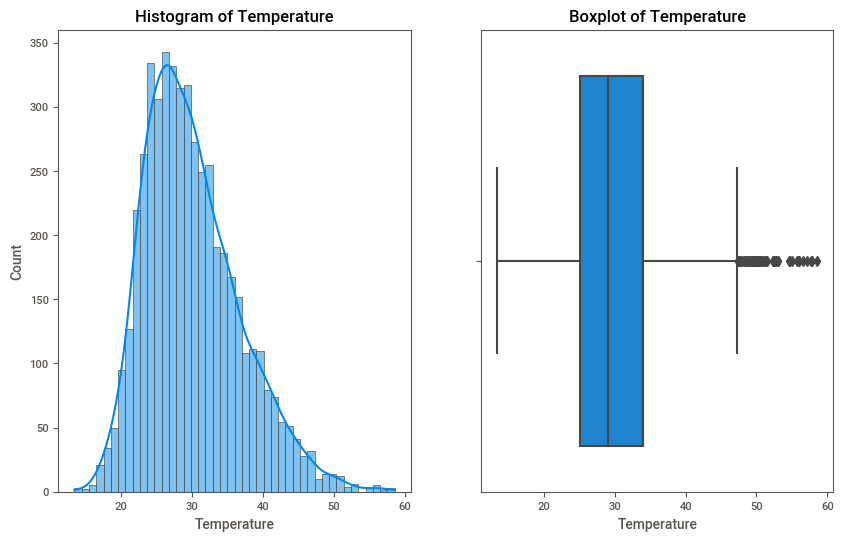

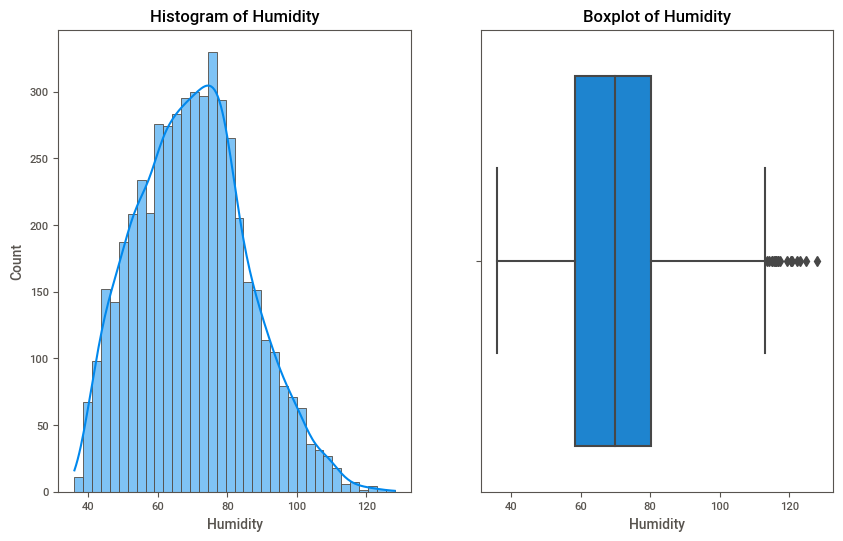

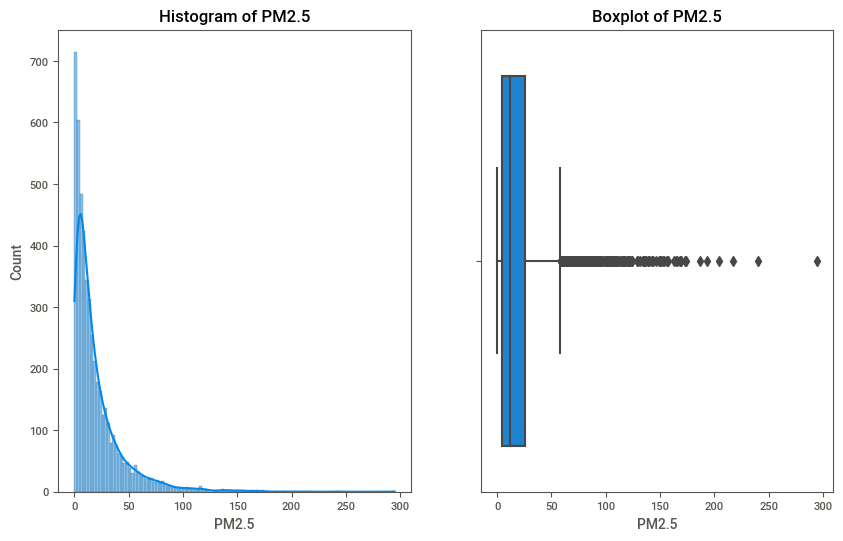

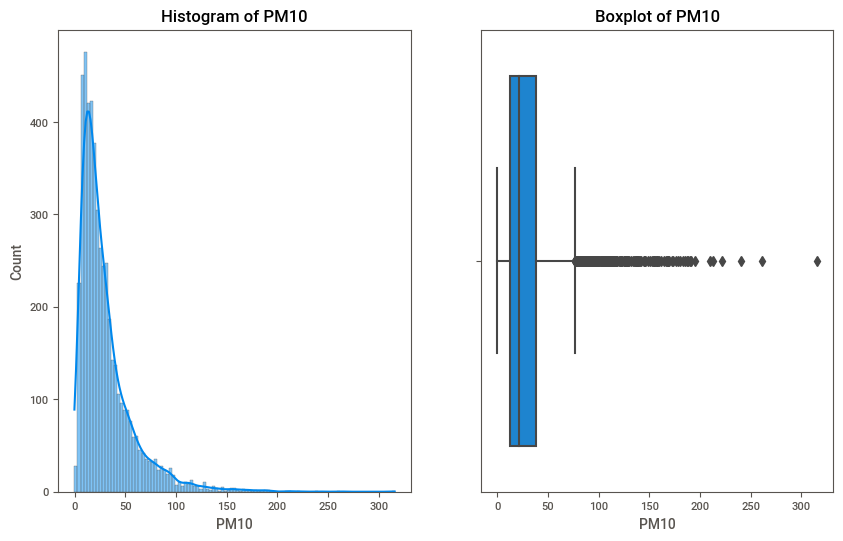

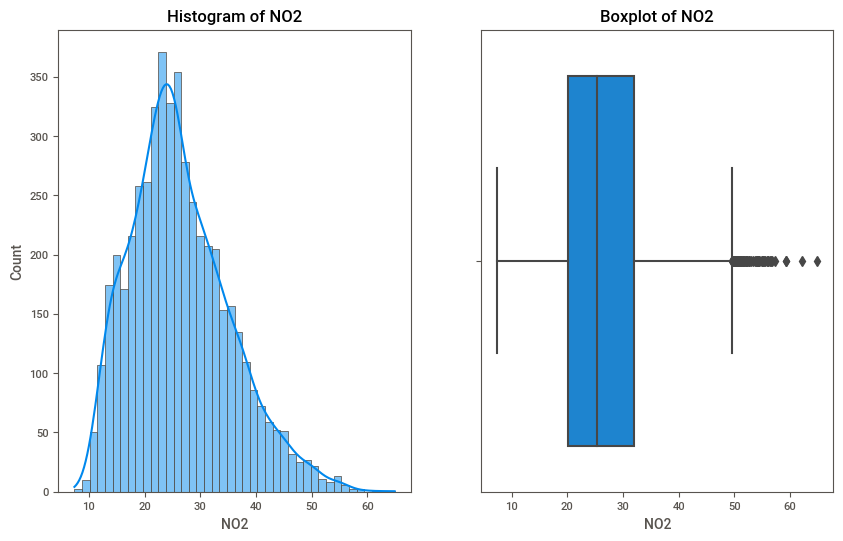

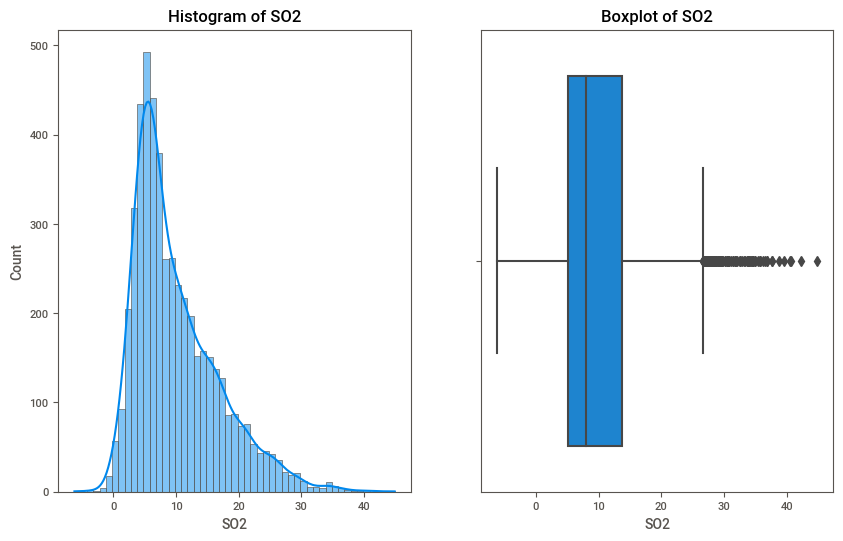

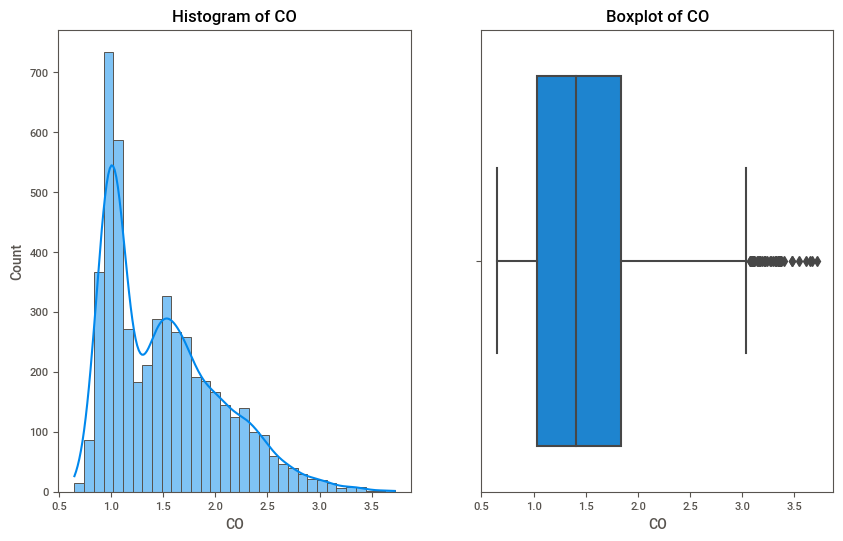

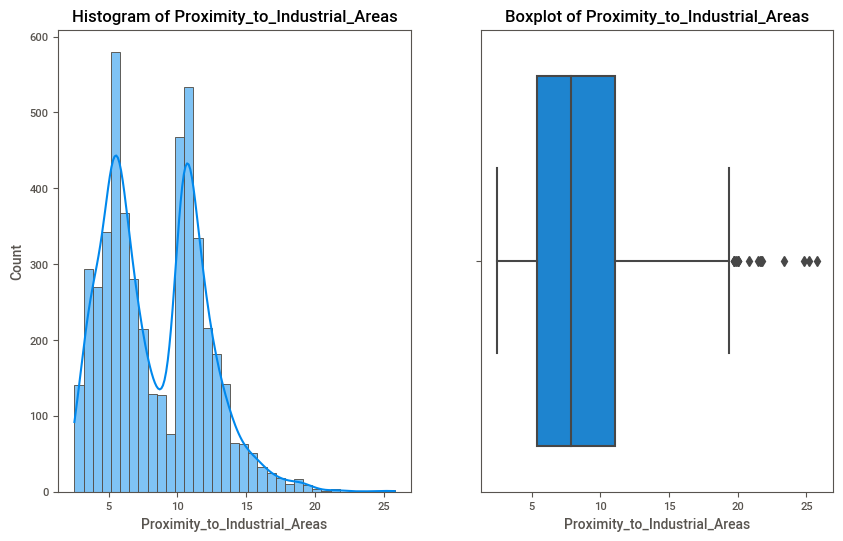

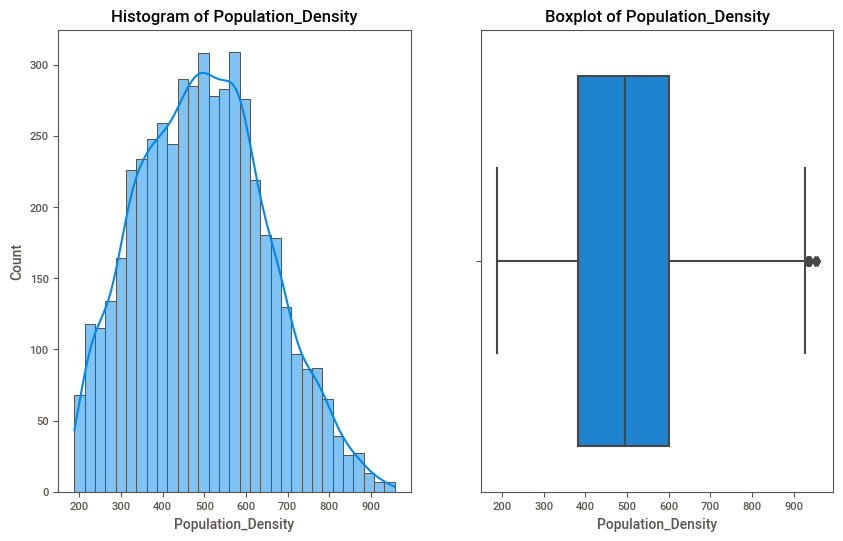

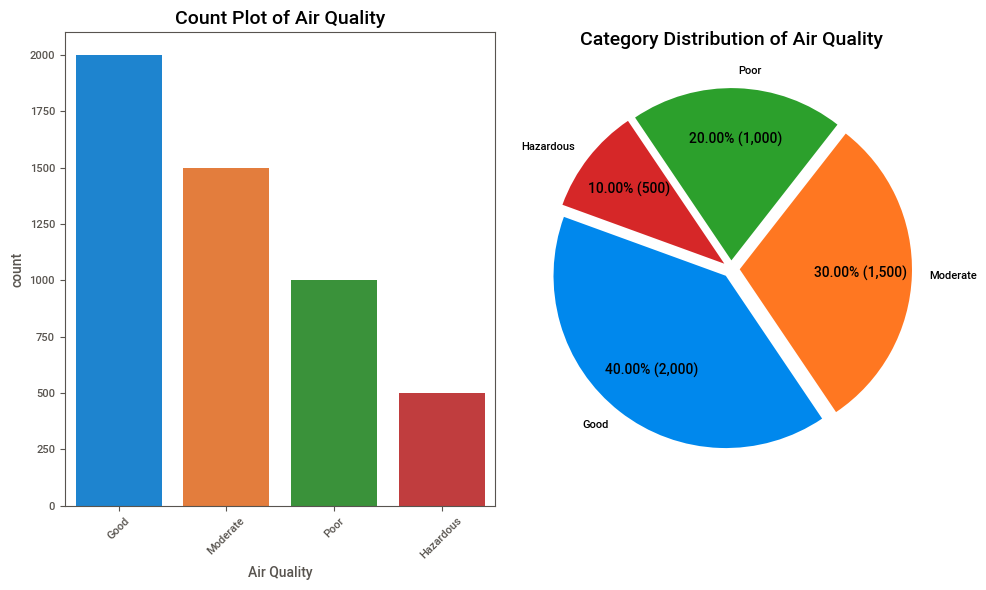

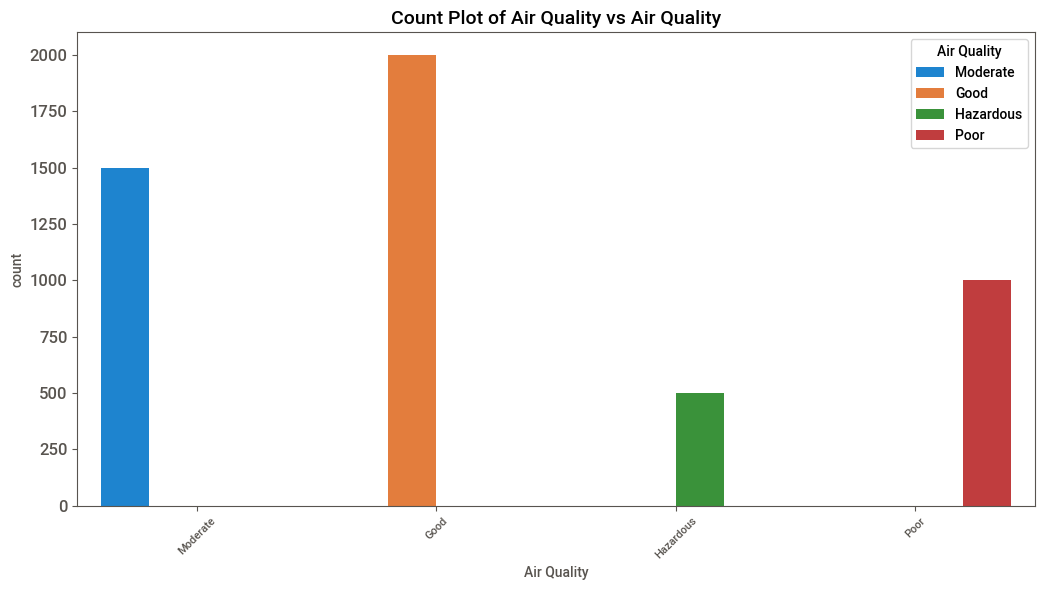

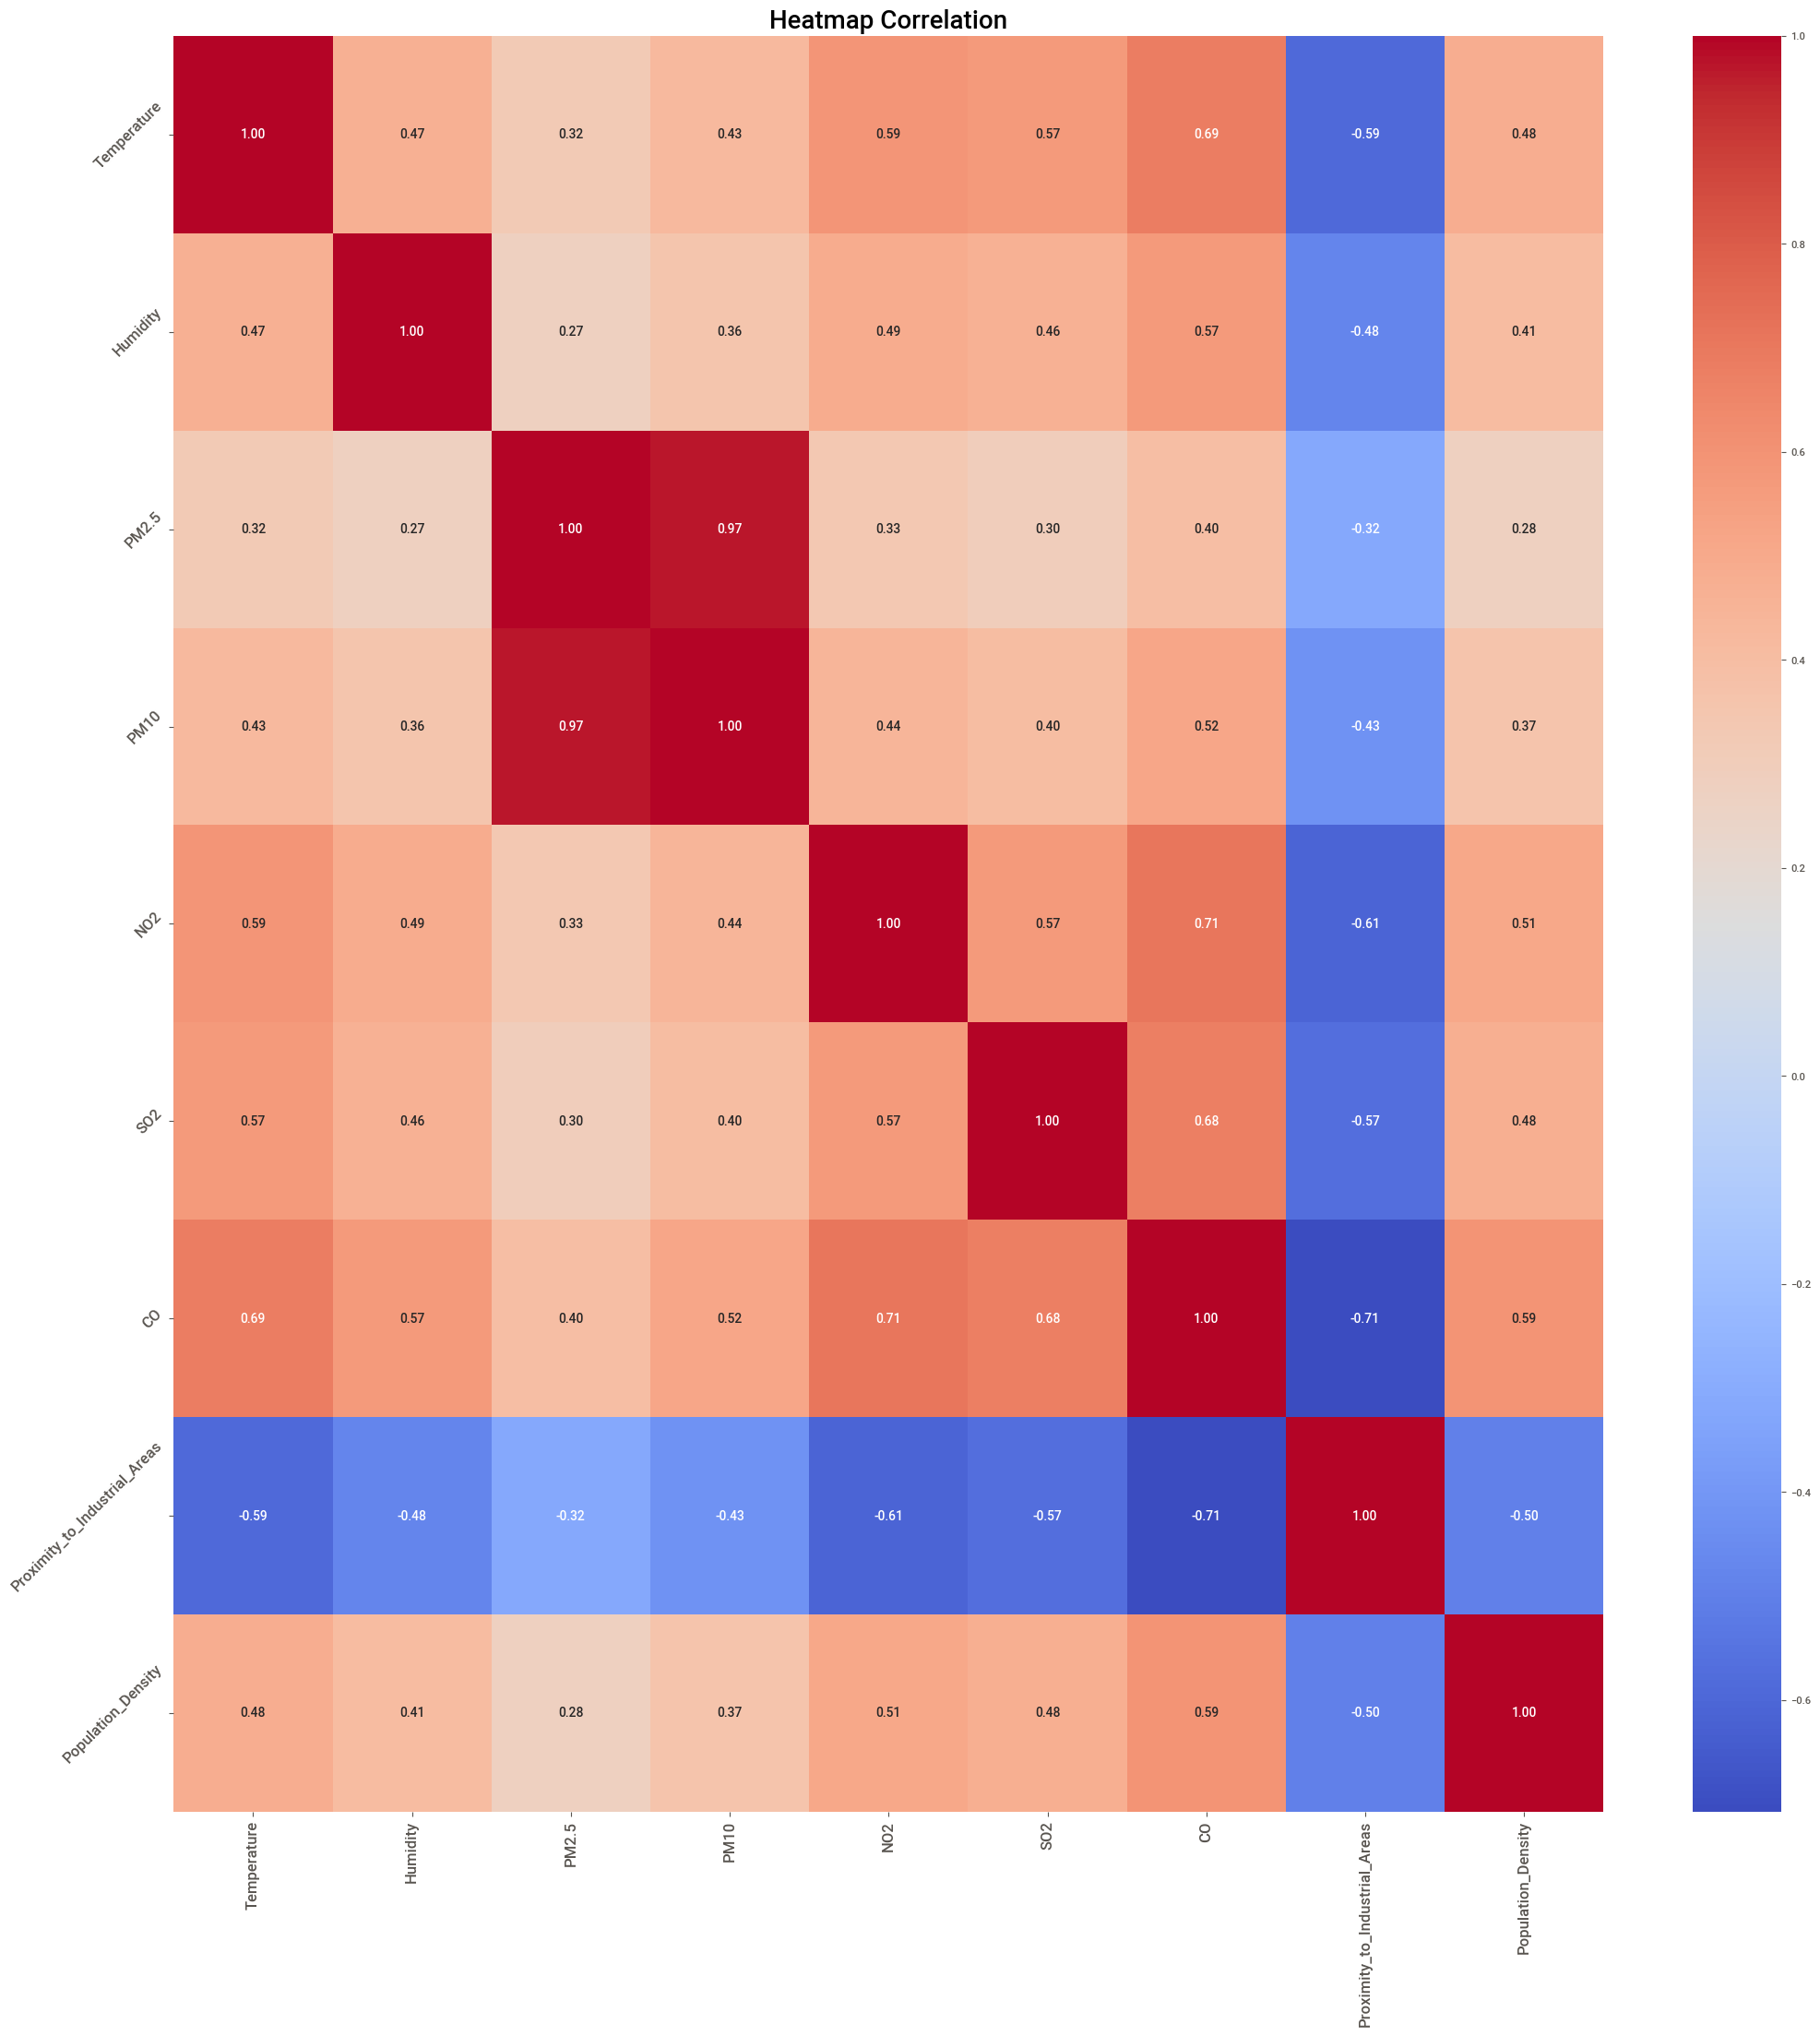

                                             |                                             | [  0%]   00:00 ->…

Report pre_dataclean_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [65]:
analyze_data(data,target='Air Quality', report_name="pre_dataclean_report.html",multivariate_check=True)

##### From the above plots and report, clearly we can see that data is having imbalace issue, will take care of it in the second iteration if it is impacting model performance on minor class

### Encode the target variable

In [66]:
class_names = data['Air Quality'].unique()
encoder = LabelEncoder() # lets encode the target variable
data["Air Quality"] = encoder.fit_transform(data["Air Quality"])

### Handling Outliers

##### As we can see that clearly, few of the feature are facing outlier issue

In [67]:
cols_with_outs = ["PM10", "NO2", "SO2", "CO"]
threshold = 2.5
for col in cols_with_outs:
    zscore = stats.zscore(data[col])
    data = data[(zscore >= -threshold) & (zscore <= threshold)]

### Handling Data Correlation

##### since feature "PM2.5" and "PM10" were almost highly correlated, we can drop any one of the feature

In [68]:
data = data.drop('PM2.5',axis=1)
data.head(2)

,Temperature,Humidity,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.80,59.10,17.90,18.90,9.20,1.72,6.30,319,2
1,28.30,75.60,12.20,30.80,9.70,1.64,6.00,611,2


#### Generate report post data preprocess

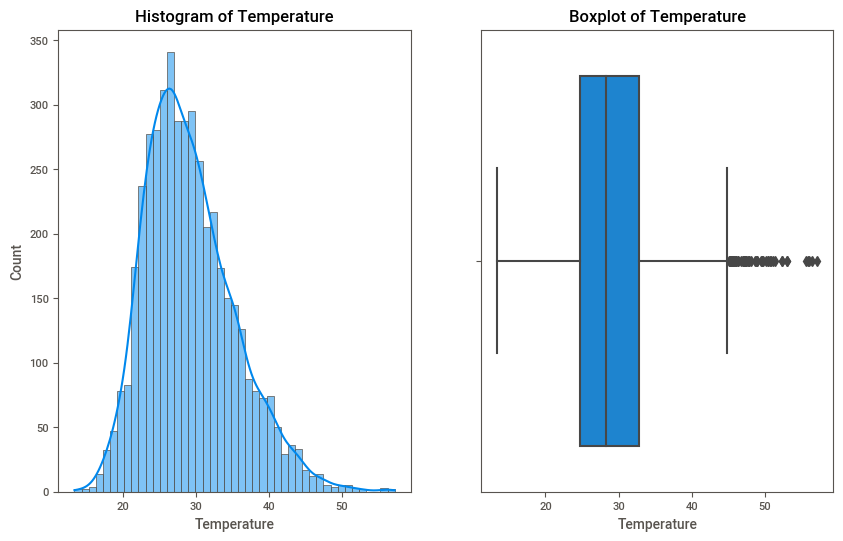

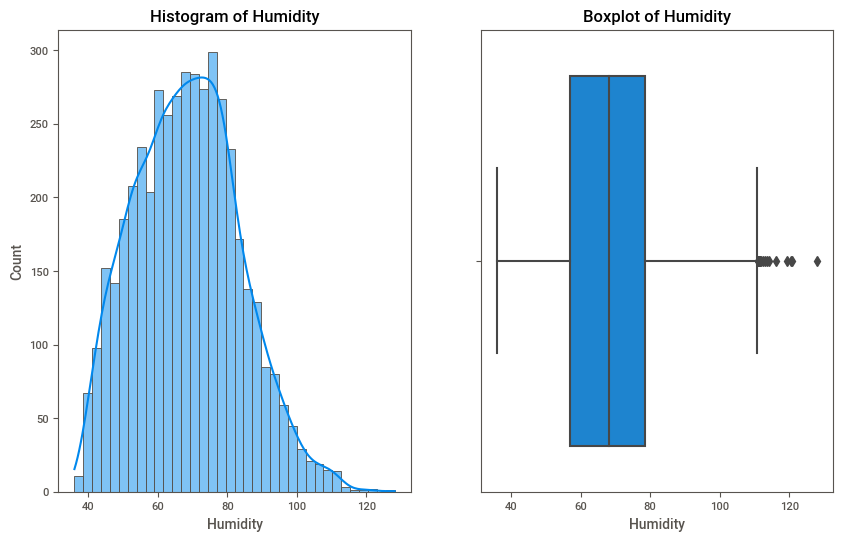

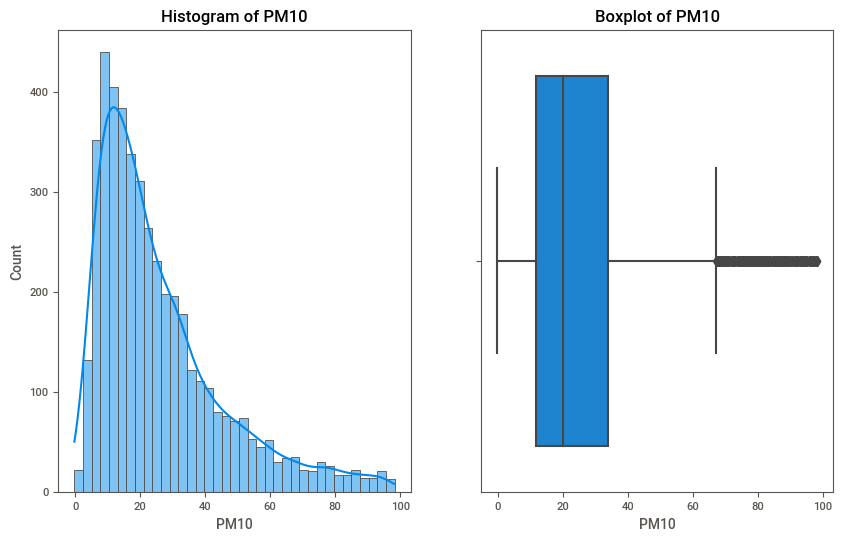

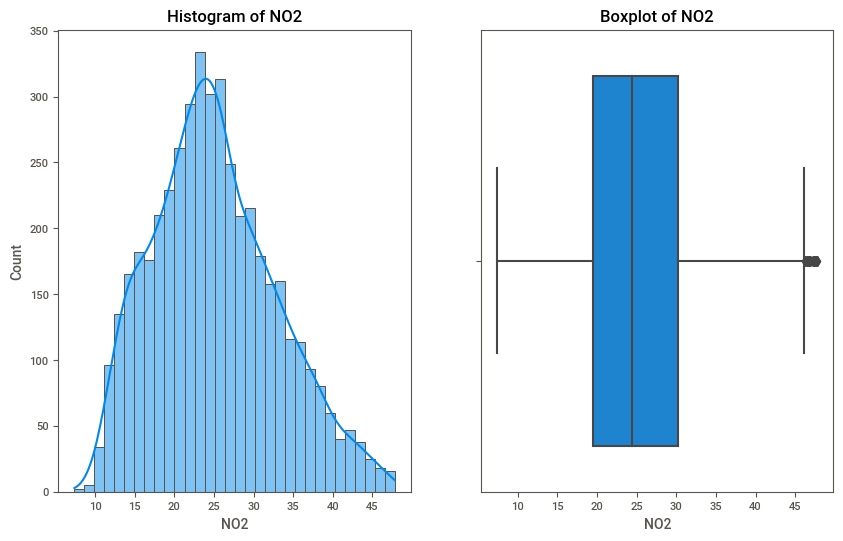

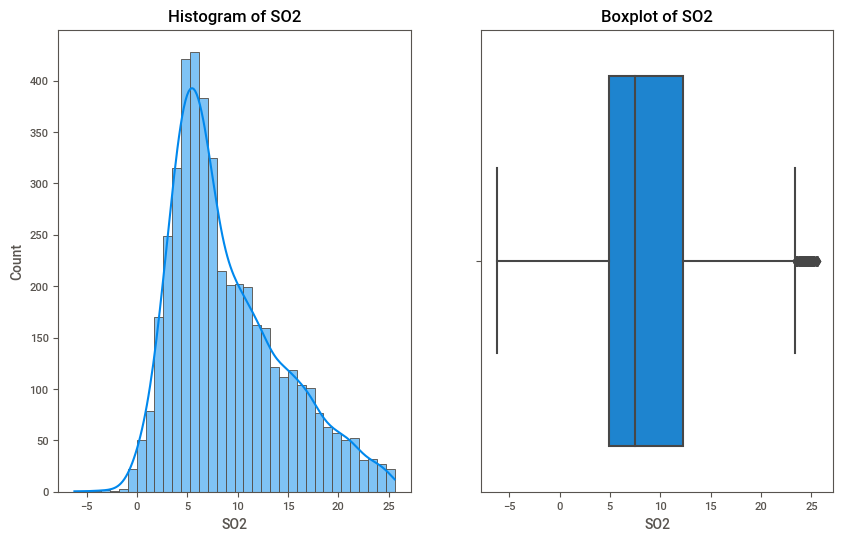

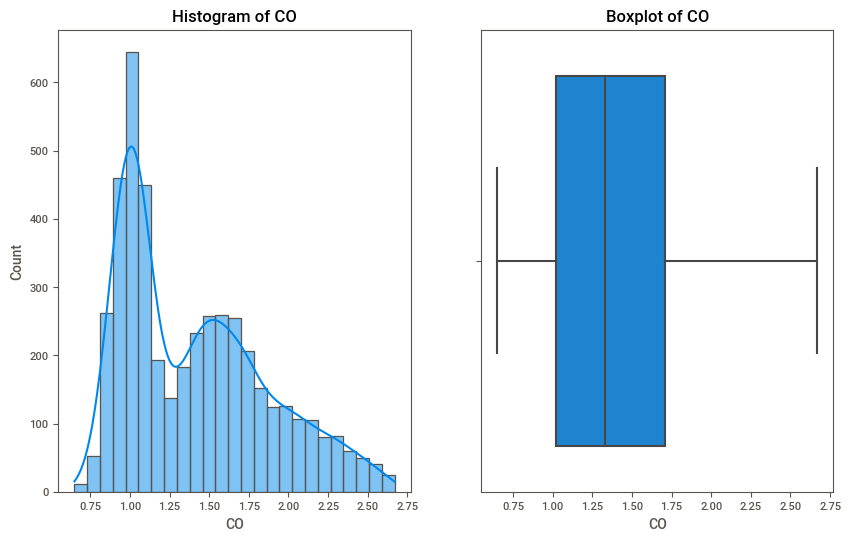

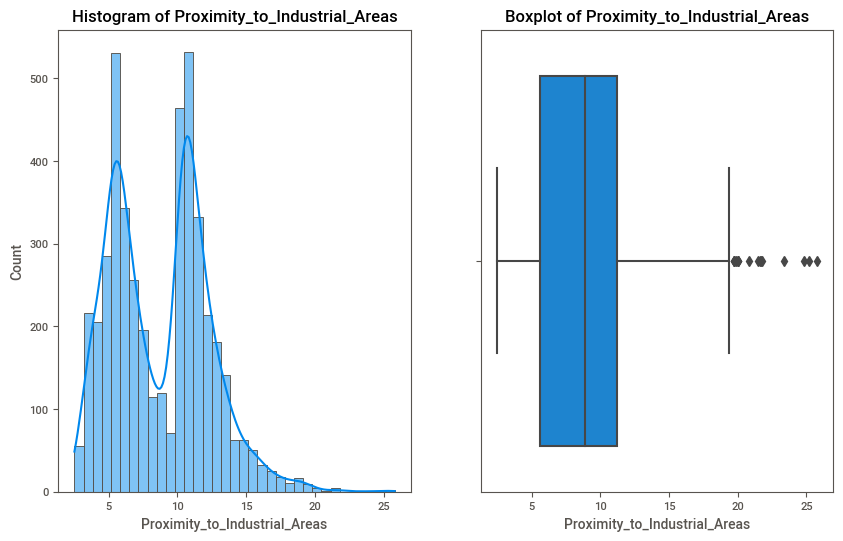

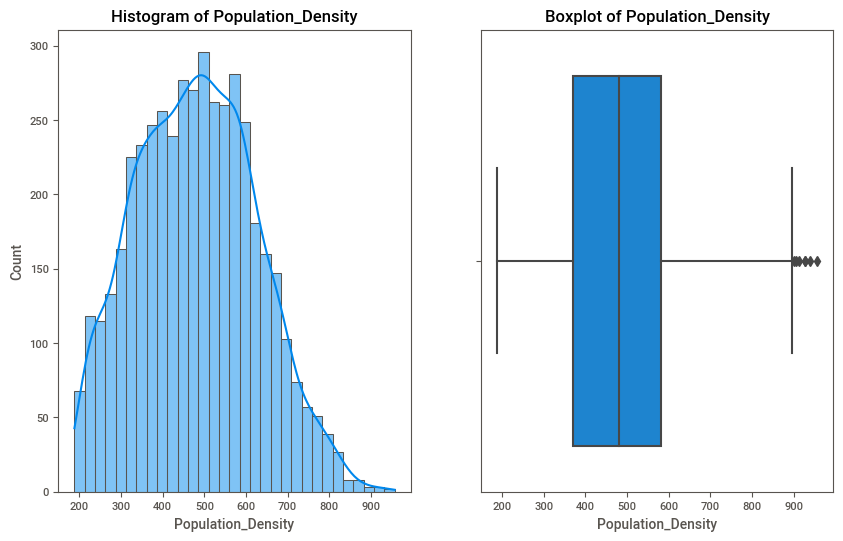

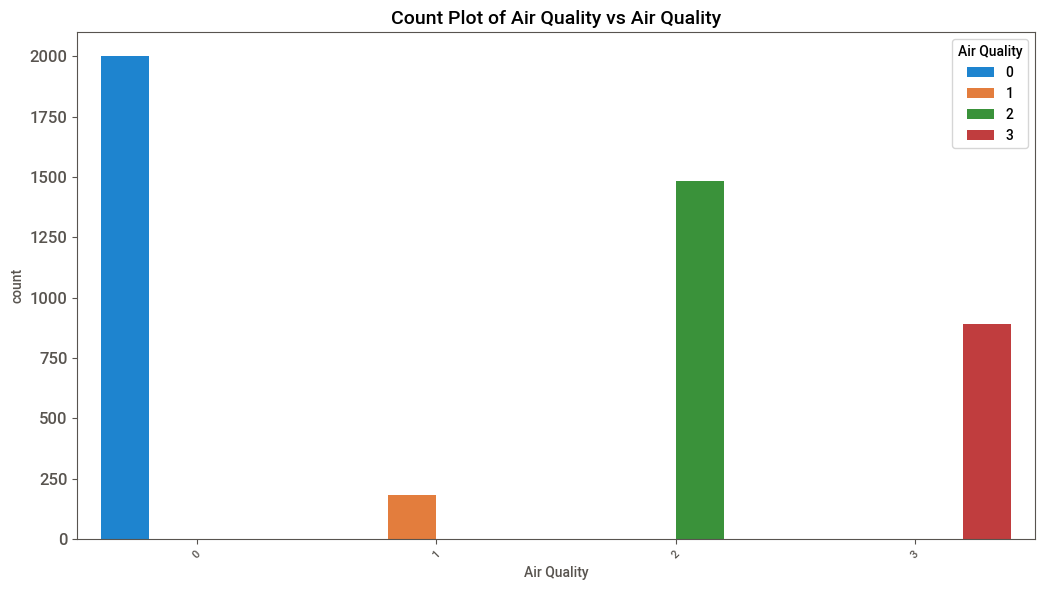

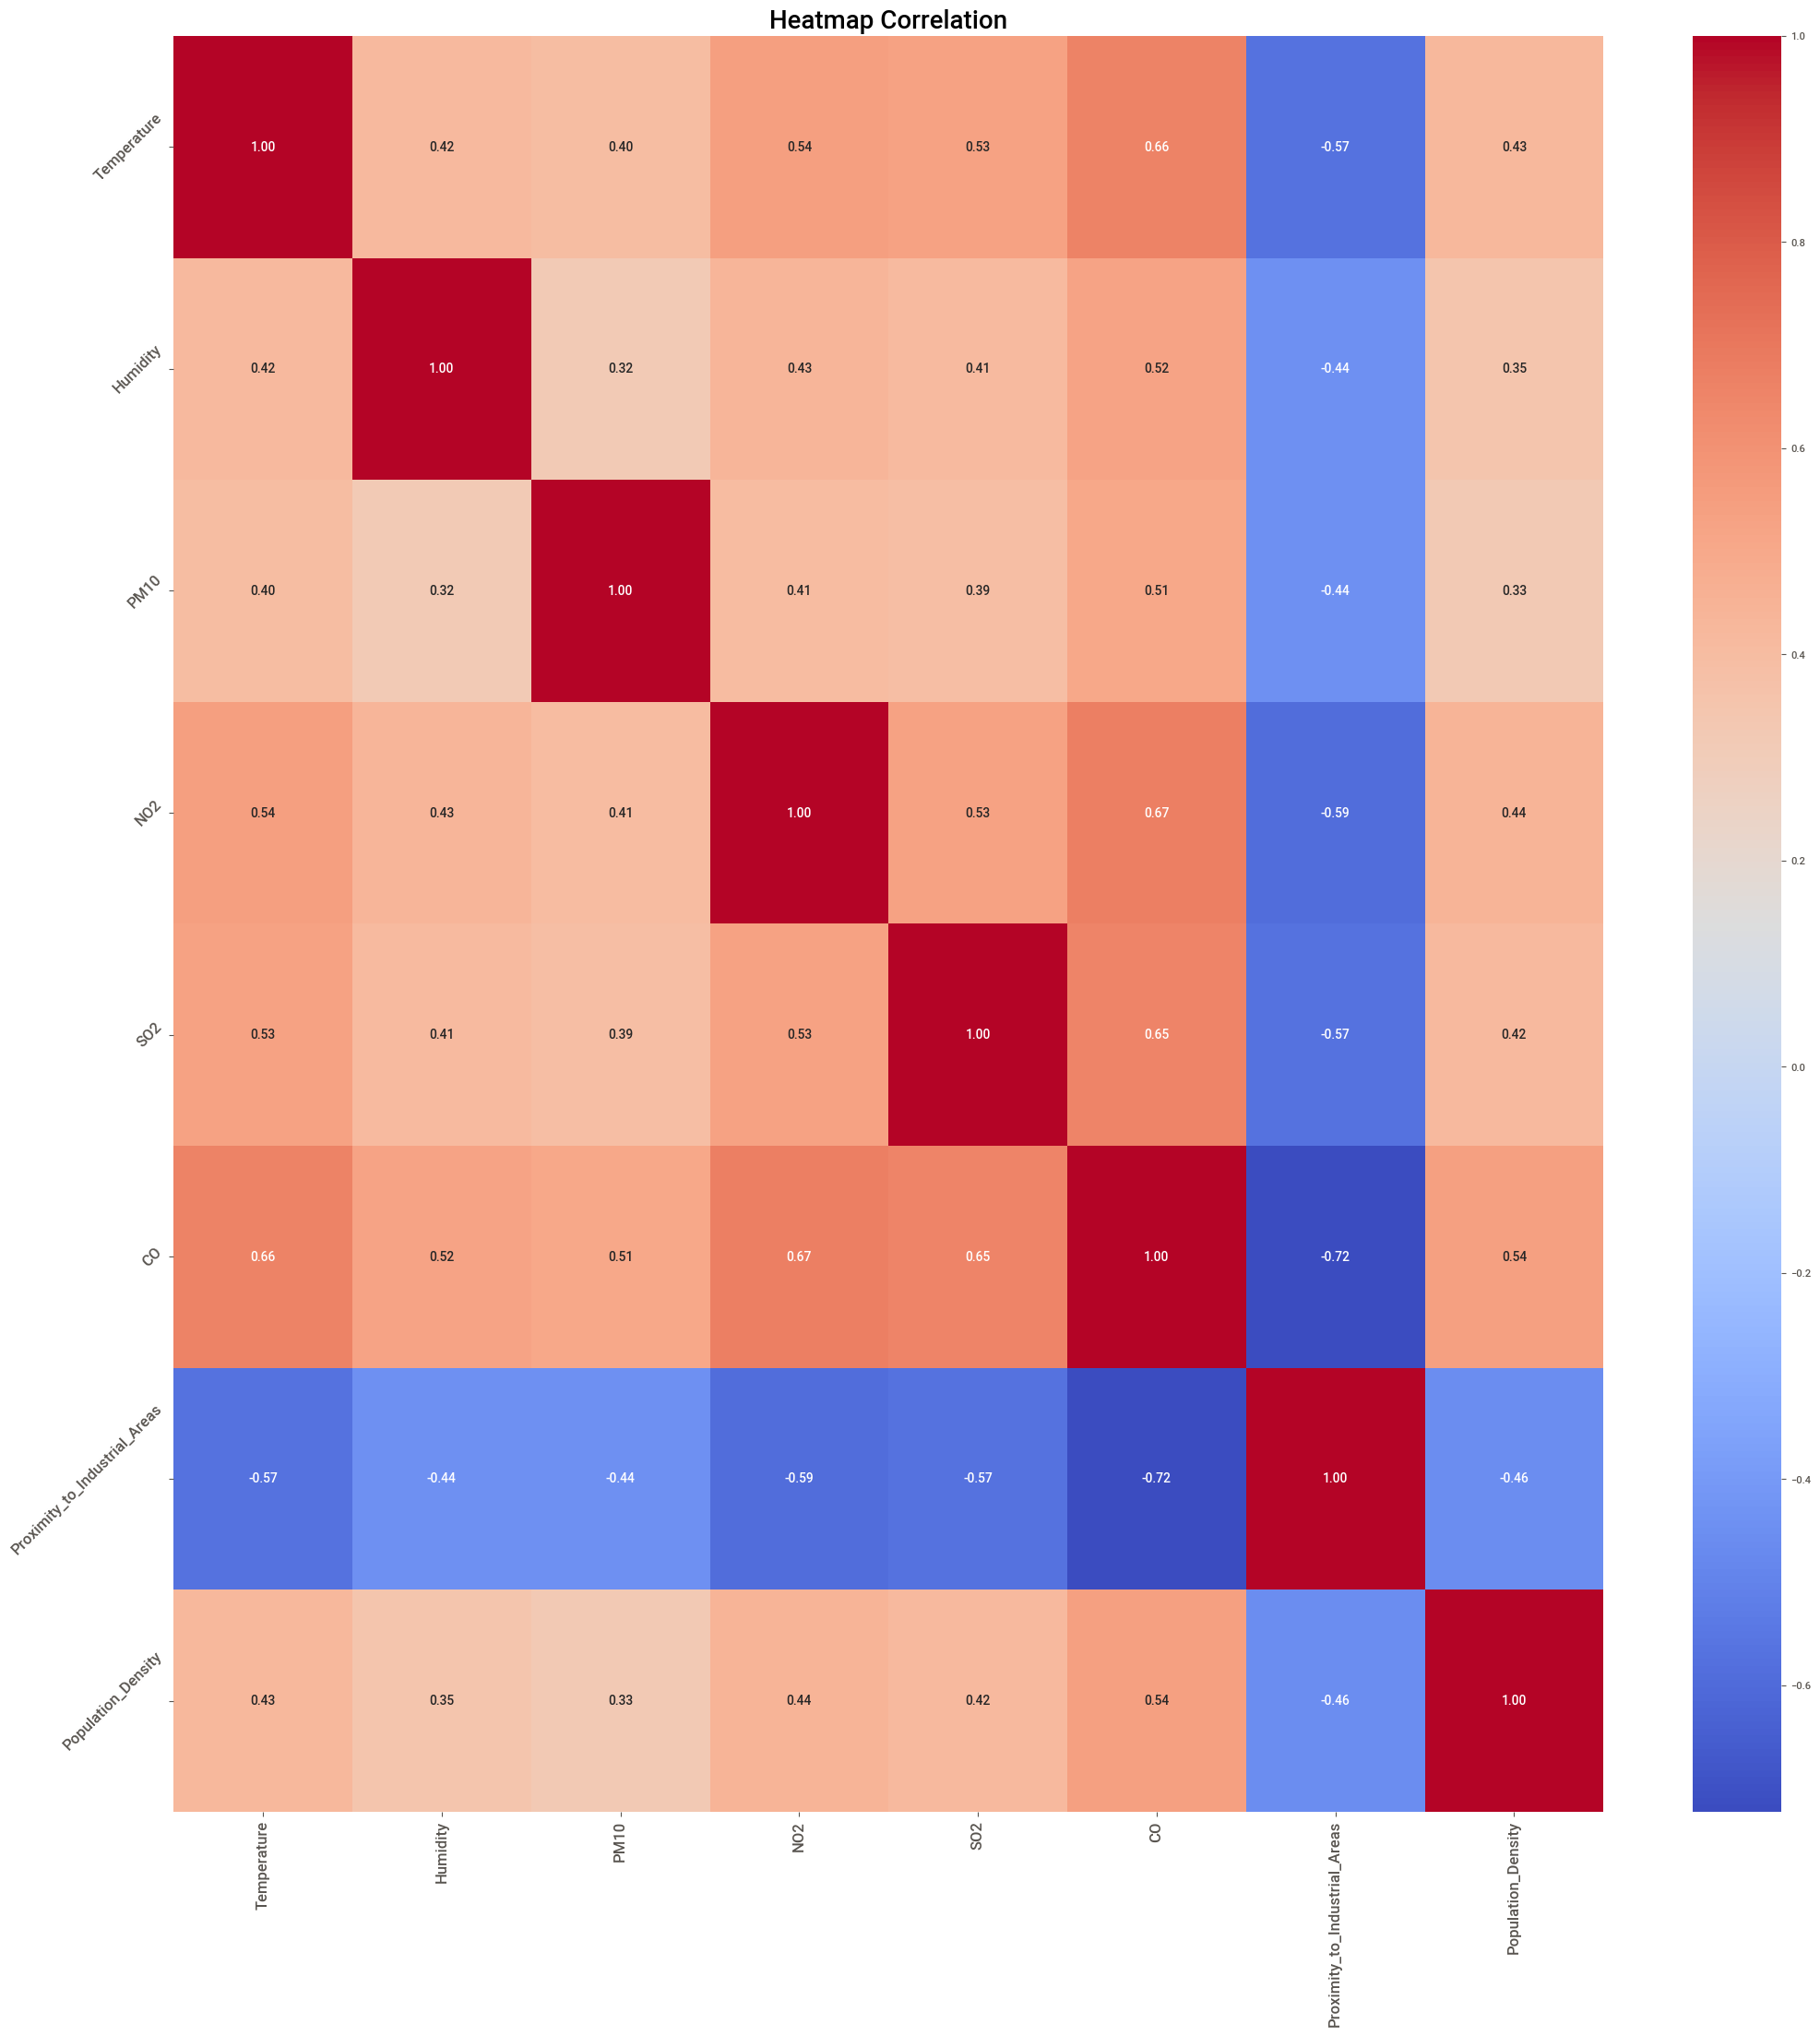

                                             |                                             | [  0%]   00:00 ->…

Report post_dataclean_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [69]:
analyze_data(data,target='Air Quality', report_name="post_dataclean_report.html",multivariate_check=True)

#### Feature Importance 

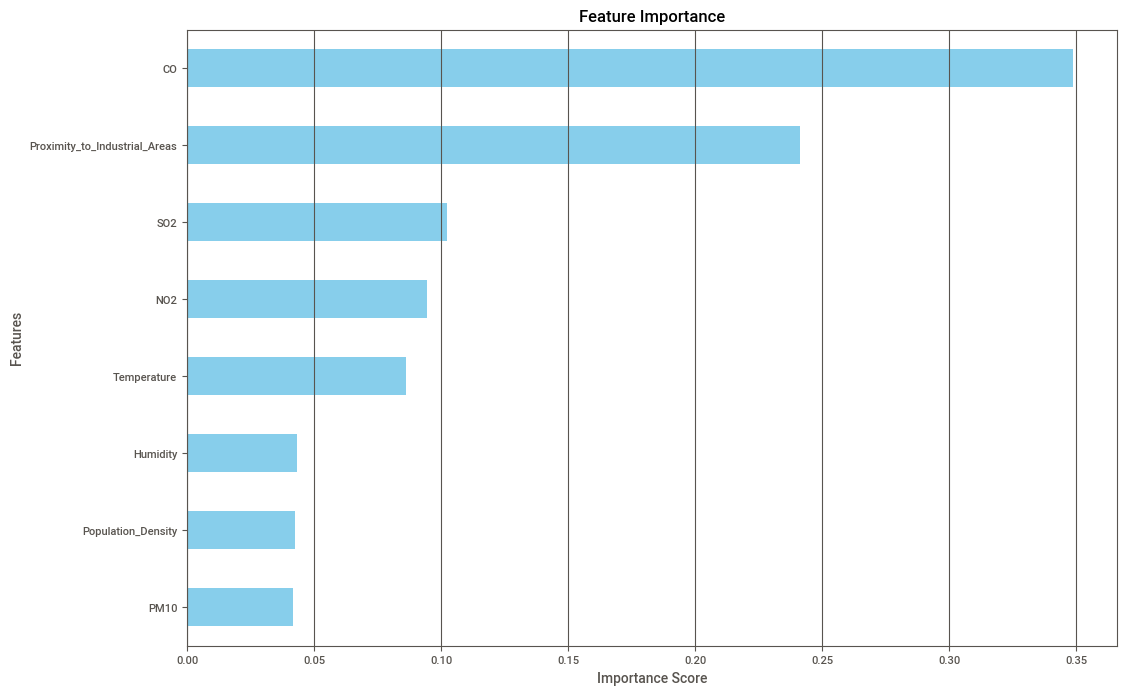

In [70]:
# Defining X (features) and y (target)
num_cols = data.select_dtypes(include=['int32','int64', 'float64']).columns
X = data[num_cols].drop(["Air Quality"], axis=1)  # Drop the target column
y = data["Air Quality"]

# Defining the Random Forest model and fitting it
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Getting feature importance
importance = model.feature_importances_

# Summarizing feature importance
# print("Feature Importance Scores:")
# for i, v in enumerate(importance):
#     print(f"Feature: {X.columns[i]}, Score: {v:.4f}")

# Creating a sorted Series for plotting
feature_importance_series = pd.Series(importance, index=X.columns).sort_values()

# Plotting feature importance (sorted)
plt.figure(figsize=(12, 8))
feature_importance_series.plot(kind="barh", color="skyblue")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(axis="x")
plt.show()

##### >>> Note: As a overview, we can see that 'CO', 'Proximity_to_Industrial_Areas', 'S02' etc having high feature importance 

##### We were able to clean the data for some extent but not fully, since data size is less

### Data Modeling

In [71]:
X = data.drop("Air Quality", axis=1)
y = data["Air Quality"]
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.20, shuffle=True) # considering only 20% for test

#### Data Normalization

In [72]:
scaler = StandardScaler()
X_norm = X
X_norm = scaler.fit_transform(X_norm)

Xnorm_train, Xnorm_test, Y_train, Y_test = train_test_split(X_norm, Y, shuffle=True, test_size=.20)

### Model Training

#### Training on UnNormalized dataset

##### Random Forest Classifier

In [73]:
RF_model = RandomForestClassifier(n_estimators=200, max_depth=350, n_jobs=-1)
RF_model.fit(X_train, Y_train)
pred1 = RF_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.77      0.46      0.57       688
           1       0.00      0.00      0.00         0
           2       0.21      0.34      0.26       197
           3       0.03      0.19      0.06        26

    accuracy                           0.42       911
   macro avg       0.25      0.25      0.22       911
weighted avg       0.63      0.42      0.49       911



<AxesSubplot: >

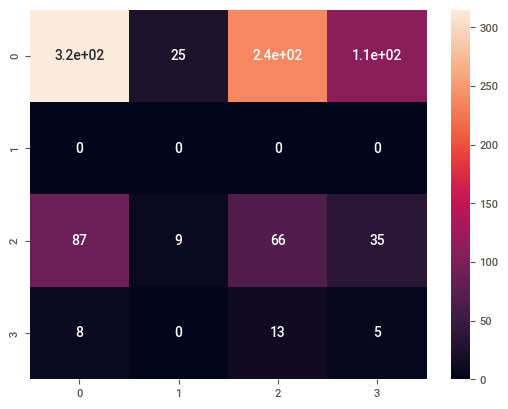

In [74]:
# lets evaluate the model 
print(classification_report(pred1, Y_test))
sns.heatmap(confusion_matrix(pred1, Y_test), annot=True)

##### Support Vector Classifier

In [75]:
sv_model = SVC(kernel="rbf", C=2.0, gamma=0.09)
sv_model.fit(X_train, Y_train)
pred2 = sv_model.predict(X_test)


              precision    recall  f1-score   support

           0       0.99      0.45      0.62       905
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         1

    accuracy                           0.44       911
   macro avg       0.25      0.11      0.15       911
weighted avg       0.98      0.44      0.61       911



<AxesSubplot: >

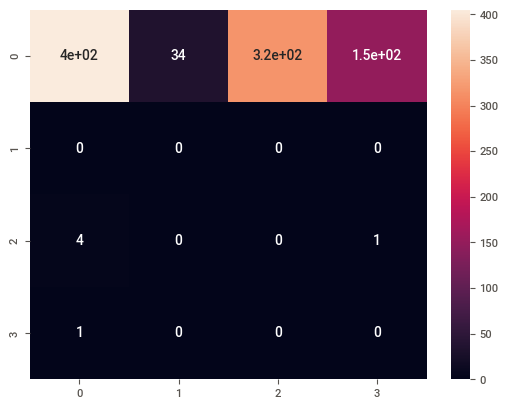

In [76]:
# lets evaluate the svc base model

print(classification_report(pred2, Y_test))
sns.heatmap(confusion_matrix(pred2, Y_test), annot=True)

#### Training on Normalized dataset

##### Random Forest Classifier

In [77]:
RF_model = RandomForestClassifier(n_estimators=200, max_depth=350, n_jobs=-1)
RF_model.fit(Xnorm_train, Y_train)
pred3 = RF_model.predict(Xnorm_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       411
           1       0.65      0.92      0.76        24
           2       0.95      0.97      0.96       309
           3       0.93      0.84      0.88       167

    accuracy                           0.96       911
   macro avg       0.88      0.93      0.90       911
weighted avg       0.96      0.96      0.96       911



<AxesSubplot: >

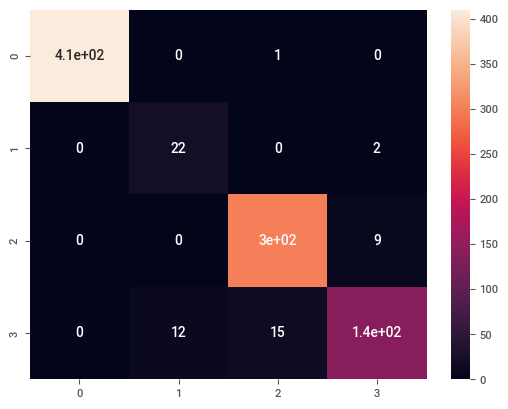

In [78]:
# lets evaluate the random forest model
print(classification_report(pred3, Y_test))
sns.heatmap(confusion_matrix(pred3, Y_test), annot=True)

##### Support Vector Classifier

In [79]:
sv_model = SVC(kernel="rbf", C=2.0, gamma=0.09)
sv_model.fit(Xnorm_train, Y_train)
pred4 = sv_model.predict(Xnorm_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       410
           1       0.53      0.75      0.62        24
           2       0.95      0.96      0.95       314
           3       0.87      0.80      0.83       163

    accuracy                           0.94       911
   macro avg       0.84      0.88      0.85       911
weighted avg       0.95      0.94      0.94       911



<AxesSubplot: >

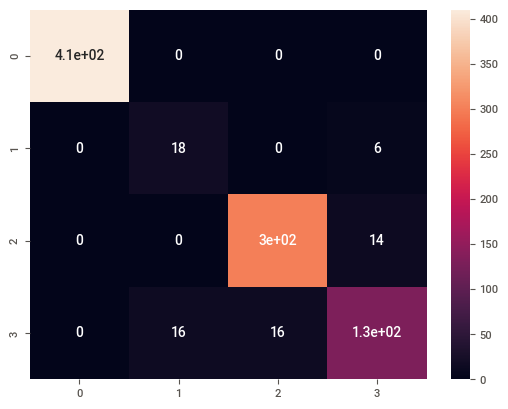

In [80]:
# lets evaluate the model 
print(classification_report(pred4, Y_test))
sns.heatmap(confusion_matrix(pred4, Y_test), annot=True)

##### Clearly we can say that, scaled data is helping model to get train well 

##### XGBoost Classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       411
           1       0.68      0.92      0.78        25
           2       0.94      0.96      0.95       308
           3       0.91      0.83      0.87       167

    accuracy                           0.95       911
   macro avg       0.88      0.93      0.90       911
weighted avg       0.96      0.95      0.95       911



<AxesSubplot: >

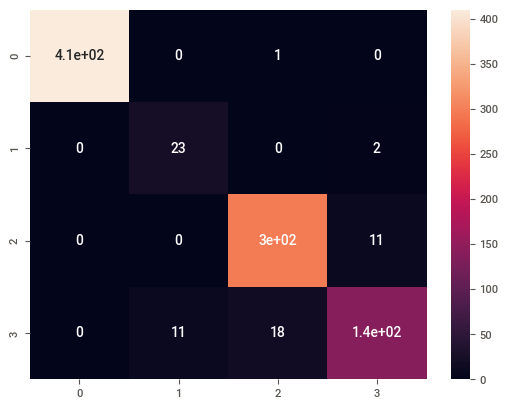

In [81]:
xg_model = XGBClassifier(n_estimators=200,max_depth=350, n_jobs=-1)
xg_model.fit(Xnorm_train, Y_train)
pred5 = xg_model.predict(Xnorm_test)

# lets evaluate the model
print(classification_report(pred5, Y_test))
sns.heatmap(confusion_matrix(pred5, Y_test), annot=True)

###### We can sense that Random Forest is doing good on the current version of dataset, let try some hypertuning on the Random Forest.

In [82]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],       
    'max_depth': [50, 100, 200, 300, 350, None],     
    'max_features': ['auto', 'sqrt', 'log2'],        
    'min_samples_split': [2, 5, 10],                
    'min_samples_leaf': [1, 2, 4],                
    'bootstrap': [True, False]                     
}

# Initialize Random Forest model
RF_model = RandomForestClassifier(n_jobs=-1, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RF_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=20,        # Number of random combinations to try
                                   cv=5,             # 5-fold cross-validation
                                   scoring='accuracy', 
                                   n_jobs=-1, 
                                   verbose=1, 
                                   random_state=42)

# Fit RandomizedSearchCV
random_search.fit(Xnorm_train, Y_train)

# Get the best parameters
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {random_search.best_score_:.3f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 300, 'bootstrap': True}
Best Cross-Validation Accuracy: 0.959


 #### Train the final model with the best parameters

In [83]:
best_params = random_search.best_params_
RF_final = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42)
RF_final.fit(Xnorm_train, Y_train)

RandomForestClassifier(max_depth=300, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=500, n_jobs=-1, random_state=42)

### Model Evaluation

In [84]:
def evaluate_model(model, X_test, y_test, class_names=None):
    """
    Evaluates a classification model on test data and displays key metrics, 
    a confusion matrix heatmap, and a classification report.
    
    Parameters:
        model: Trained classification model.
        X_test (pd.DataFrame or np.ndarray): Test features.
        y_test (pd.Series or np.ndarray): True labels for the test set.
        class_names (list, optional): List of class names for the confusion matrix.
        
    Returns:
        None
    """
    # Predict on test data
    y_preds = model.predict(X_test)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds, average="weighted")
    recall = recall_score(y_test, y_preds, average="weighted")
    f1 = f1_score(y_test, y_preds, average="weighted")
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_preds, target_names=class_names))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_preds)
    
    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


#### Evaluate  Final version of Trained Model

Accuracy: 0.957
Precision: 0.960
Recall: 0.957
F1 Score: 0.956

Classification Report:
              precision    recall  f1-score   support

    Moderate       1.00      1.00      1.00       410
        Good       0.95      0.59      0.73        34
   Hazardous       0.97      0.95      0.96       316
        Poor       0.83      0.93      0.88       151

    accuracy                           0.96       911
   macro avg       0.94      0.87      0.89       911
weighted avg       0.96      0.96      0.96       911



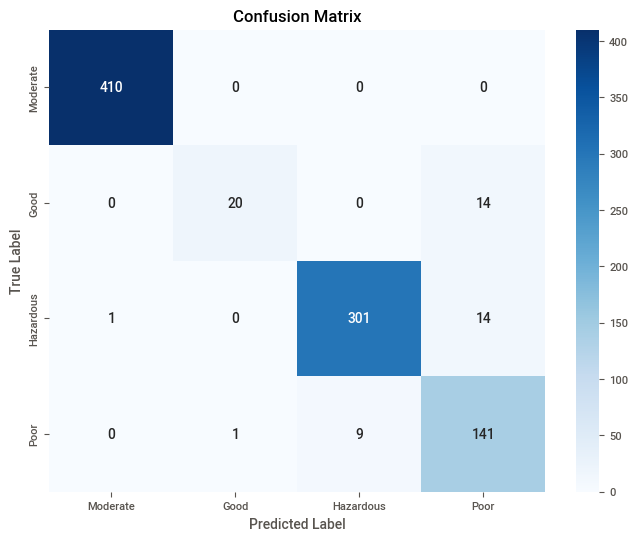

In [85]:
evaluate_model(RF_final,Xnorm_test,Y_test,class_names=class_names)

##### We were able to achieve Precision and Recall of "96.5%" despite the data is having little imbalance issue

### Save and Load the Model

#### Saving the model

In [87]:
joblib.dump(RF_final, 'model-checkpoints/random_forest_model_v_9-6.pkl')
print("Model saved successfully.")

Model saved successfully.


#### Loading the Saved Model

In [89]:
RF_loaded = joblib.load('model-checkpoints/random_forest_model_v_9-6.pkl')
print("Model loaded successfully.")

Model loaded successfully.


#### Test the loaded model

In [93]:
# Make predictions using the loaded model
pred_loaded = RF_loaded.predict(Xnorm_test)

# Evaluate the loaded model
accuracy_loaded = accuracy_score(Y_test, pred_loaded)
precision_loaded = precision_score(Y_test, pred_loaded, average='weighted')
recall_loaded = recall_score(Y_test, pred_loaded, average='weighted')
f1_loaded = f1_score(Y_test, pred_loaded, average='weighted')

print(f"Test Accuracy : {accuracy_loaded:.3f}")
print(f"Test Precision : {precision_loaded:.3f}")
print(f"Test Recall : {recall_loaded:.3f}")
print(f"Test F1 Score : {f1_loaded:.3f}")


Test Accuracy : 0.957
Test Precision : 0.960
Test Recall : 0.957
Test F1 Score : 0.956
